In [1]:
# uni_D83AE5_uni (Baseline)
# {"Logloss": 0.028862768444821975, "ROCAUC": 0.9784058122382846}
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns
from scipy.stats import gamma, kstest
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
import xgboost as xgb
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report, 
    confusion_matrix, 
    log_loss, 
    roc_auc_score, 
    roc_curve, 
    auc
)
import statsmodels.api as sm
import warnings

warnings.filterwarnings('ignore')  # Use this line to suppress warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

training_data = pd.read_csv('training_data.csv')
training_data = training_data[training_data['BORROWER_ID'] != 'xNullx']
training_data = training_data.sample(frac=1, random_state=42).reset_index(drop=True)
data_submission_example = pd.read_csv('data_submission_example.csv')

In [2]:
training_data.fillna(0, inplace=True)
for col in training_data.columns:
    try:
        training_data[col] = pd.to_numeric(training_data[col], errors='ignore')
    except:
        continue
training_data['TARGET_EVENT_BINARY'] = np.where(training_data['TARGET_EVENT'] == 'K', 1, 0)

In [3]:
lognormal_variables = [
    'CONTRACT_CREDIT_LOSS', 'CONTRACT_DEPT_SERVICE_TO_INCOME',
    'CONTRACT_INCOME', 'CONTRACT_INSTALMENT_AMOUNT', 'CONTRACT_INSTALMENT_AMOUNT_2',
    'CONTRACT_LOAN_AMOUNT', 'CONTRACT_MARKET_VALUE', 'CONTRACT_MORTGAGE_LENDING_VALUE', 
    'CONTRACT_LGD', 'CONTRACT_INCOME'
]
date_variables = ['CONTRACT_DATE_OF_LOAN_AGREEMENT', 'CONTRACT_MATURITY_DATE']

In [4]:
training_data['TARGET_EVENT_DAY'].replace(0.0, np.nan, inplace=True)
training_data['TARGET_EVENT_DAY_JULIAN'] = pd.to_datetime(training_data['TARGET_EVENT_DAY'], origin='julian', unit='D', errors='coerce')
training_data['TARGET_EVENT_DAY_DATETIME'] = pd.to_datetime(training_data['TARGET_EVENT_DAY_JULIAN'],  errors='coerce')

training_data['CONTRACT_DATE_OF_LOAN_AGREEMENT_JULIAN'] = pd.to_datetime(training_data['CONTRACT_DATE_OF_LOAN_AGREEMENT'], origin='julian', unit='D')
training_data['CONTRACT_DATE_OF_LOAN_AGREEMENT_DATETIME'] = pd.to_datetime(training_data['CONTRACT_DATE_OF_LOAN_AGREEMENT_JULIAN'],)

training_data['CONTRACT_MATURITY_DATE_JULIAN'] = pd.to_datetime(training_data['CONTRACT_MATURITY_DATE'], origin='julian', unit='D')
training_data['CONTRACT_MATURITY_DATE_DATETIME'] = pd.to_datetime(training_data['CONTRACT_MATURITY_DATE_JULIAN'])

In [5]:
training_data['DAY_DIFF'] = (training_data['TARGET_EVENT_DAY_DATETIME'] - training_data['CONTRACT_DATE_OF_LOAN_AGREEMENT_DATETIME']).dt.days

In [6]:
def create_binary_target_column(dataframe, column_name, event, day_diff_upper_limit):
    dataframe[column_name] = np.where(
        (dataframe['TARGET_EVENT'] == event) & 
        (dataframe['DAY_DIFF'] <= day_diff_upper_limit) & 
        (dataframe['DAY_DIFF'] >= 0), 
        1, 
        0
    )

timeframes = {
    'TARGET_EVENT_BINARY_2Y': 730,
    'TARGET_EVENT_BINARY_1Y': 365,
    'TARGET_EVENT_BINARY_6M': 365//2,
}

for column_name, days in timeframes.items():
    create_binary_target_column(training_data, column_name, 'K', days)


# target_event_binary_columns = []
# for i in range(6):
#     start_day = 273 + i * 30
#     column_header = 'TARGET_EVENT_BINARY_' + str(start_day) + 'D'
#     training_data[column_header] = np.where(
#         (training_data['TARGET_EVENT'] == 'K') & 
#         (training_data['DAY_DIFF'] <= start_day) & 
#         (training_data['DAY_DIFF'] >= 0), 
#         1, 
#         0
#     )
#     target_event_binary_columns.append(column_header)

training_data.drop('DAY_DIFF', axis=1, inplace=True)

In [7]:
print(training_data['TARGET_EVENT_BINARY'].value_counts())
print(training_data['TARGET_EVENT_BINARY_2Y'].value_counts())
print(training_data['TARGET_EVENT_BINARY_1Y'].value_counts())
print(training_data['TARGET_EVENT_BINARY_6M'].value_counts())

TARGET_EVENT_BINARY
0    1590792
1      10871
Name: count, dtype: int64
TARGET_EVENT_BINARY_2Y
0    1591751
1       9912
Name: count, dtype: int64
TARGET_EVENT_BINARY_1Y
0    1596927
1       4736
Name: count, dtype: int64
TARGET_EVENT_BINARY_6M
0    1601267
1        396
Name: count, dtype: int64


In [8]:
numeric_columns = training_data.select_dtypes(include=[np.number]).columns.tolist()
excluded_keywords = ['TARGET', 'event', 'binary', 'DATE']

X_columns = [col for col in numeric_columns if all(keyword.lower() not in col.lower() for keyword in excluded_keywords)]
y_column = 'TARGET_EVENT_BINARY_2Y' 
X_columns

['CONTRACT_CREDIT_INTERMEDIARY',
 'CONTRACT_CREDIT_LOSS',
 'CONTRACT_CURRENCY',
 'CONTRACT_DEPT_SERVICE_TO_INCOME',
 'CONTRACT_INCOME',
 'CONTRACT_INSTALMENT_AMOUNT',
 'CONTRACT_INSTALMENT_AMOUNT_2',
 'CONTRACT_INTEREST_PERIOD',
 'CONTRACT_INTEREST_RATE',
 'CONTRACT_LGD',
 'CONTRACT_LOAN_AMOUNT',
 'CONTRACT_LOAN_CONTRACT_TYPE',
 'CONTRACT_LOAN_TO_VALUE_RATIO',
 'CONTRACT_MARKET_VALUE',
 'CONTRACT_MORTGAGE_LENDING_VALUE',
 'CONTRACT_MORTGAGE_TYPE',
 'CONTRACT_REFINANCED',
 'CONTRACT_RISK_WEIGHTED_ASSETS',
 'CONTRACT_TYPE_OF_INTEREST_REPAYMENT',
 'BORROWER_BIRTH_YEAR',
 'BORROWER_CITIZENSHIP',
 'BORROWER_COUNTRY',
 'BORROWER_COUNTY',
 'BORROWER_TYPE_OF_SETTLEMENT']

In [9]:
# for var in date_variables:
#     training_data[var+ '_JULIAN'] = pd.to_datetime(training_data[var], origin='julian', unit='D')

# training_data['TIME_TO_MATURITY'] = (training_data['CONTRACT_MATURITY_DATE_JULIAN'] - training_data['CONTRACT_DATE_OF_LOAN_AGREEMENT_JULIAN']).dt.days

# year_2018_date = pd.Timestamp('2018-01-01')
# training_data['TIME_TO_MATURITY'] = (training_data['CONTRACT_MATURITY_DATE_JULIAN'] - year_2018_date).dt.days
# training_data['ADJUSTED_TIME_TO_MATURITY'] = training_data['TIME_TO_MATURITY'].apply(lambda x: max(min(730, x),0))

In [10]:
loan_type_dummies = pd.get_dummies(training_data['CONTRACT_LOAN_TYPE'], prefix='LOAN_TYPE', drop_first=True)
frequency_type_dummies = pd.get_dummies(training_data['CONTRACT_FREQUENCY_TYPE'], prefix='FREQ_TYPE', drop_first=True)
training_data = pd.concat([training_data, loan_type_dummies, frequency_type_dummies], axis=1)

X_columns.extend(loan_type_dummies.columns)
X_columns.extend(frequency_type_dummies.columns)

In [11]:
training_data['BORROWER_LOAN_COUNT'] = training_data.groupby('BORROWER_ID')['BORROWER_ID'].transform('count')
training_data['LOAN_BORROWER_COUNT'] = training_data.groupby('CONTRACT_ID')['CONTRACT_ID'].transform('count')
training_data['TOTAL_LOAN_AMOUNT'] = training_data.groupby('BORROWER_ID')['CONTRACT_LOAN_AMOUNT'].transform('sum')
training_data['TOTAL_INSTALLMENT_AMOUNT_1'] = training_data.groupby('BORROWER_ID')['CONTRACT_INSTALMENT_AMOUNT'].transform('sum')
training_data['TOTAL_INSTALLMENT_AMOUNT_2'] = training_data.groupby('BORROWER_ID')['CONTRACT_INSTALMENT_AMOUNT_2'].transform('sum')
training_data['TOTAL_INSTALLMENT_AMOUNT'] = training_data['TOTAL_INSTALLMENT_AMOUNT_1'] + training_data['TOTAL_INSTALLMENT_AMOUNT_2']

X_columns.extend(['BORROWER_LOAN_COUNT', 'TOTAL_LOAN_AMOUNT','TOTAL_INSTALLMENT_AMOUNT','LOAN_BORROWER_COUNT'])
lognormal_variables.extend([ 'TOTAL_LOAN_AMOUNT','TOTAL_INSTALLMENT_AMOUNT'])

In [12]:
threshold = 0.85
correlation_matrix = training_data[X_columns].corr()
highly_correlated_set = set()
for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > threshold:
            colname = correlation_matrix.columns[i]
            highly_correlated_set.add(colname)

X_columns = [col for col in X_columns if col not in highly_correlated_set]
print('Variables removed:', highly_correlated_set)

Variables removed: {'CONTRACT_REFINANCED', 'FREQ_TYPE_2f88e16c', 'BORROWER_COUNTRY'}


In [13]:
def default_percentage_generator_2016(df, percentage, target):
    df_copy = df.copy()
    df_filtered = df_copy[df_copy['CONTRACT_DATE_OF_LOAN_AGREEMENT_DATETIME'] < '2016-01-01']
    df_mean = df_filtered[target].mean()
    print(f"Mean in year {df_mean}")
    df_defautled = df_filtered[target].sum()
    df_not_defaulted = len(df_filtered) - df_defautled

    required_val = (df_defautled - percentage * len(df_filtered))/(percentage - 1)
    
    df_filtered_after = df_copy[df_copy['CONTRACT_DATE_OF_LOAN_AGREEMENT_DATETIME'] > '2016-01-01']
    df_filtered_after = df_filtered_after[df_filtered_after[target]==1] 
    print(len(df_filtered_after))
    print(required_val)
    required_val = min(int(required_val) ,len(df_filtered_after))
    df_filtered_after = df_filtered_after.sample(n=int(required_val),random_state=42).reset_index(drop=True)

    df_filtered = pd.concat([df_filtered, df_filtered_after])

    return df_filtered

def default_percentage_generator_2017(df, percentage, target):
    df_copy = df.copy()
    df_filtered = df_copy[(df_copy['CONTRACT_DATE_OF_LOAN_AGREEMENT_DATETIME'] > '2016-01-01') &
                          (df_copy['CONTRACT_DATE_OF_LOAN_AGREEMENT_DATETIME'] < '2017-01-01')] 
    df_mean = df_filtered[target].mean()
    print(f"Mean in year 2017 {df_mean}")
    df_defautled = df_filtered[target].sum()
    df_not_defaulted = len(df_filtered) - df_defautled

    required_val = (df_defautled - percentage * len(df_filtered))/(percentage - 1)
    
    df_filtered_after = df_copy[df_copy['CONTRACT_DATE_OF_LOAN_AGREEMENT_DATETIME'] < '2016-01-01']
    df_filtered_after = df_filtered_after[df_filtered_after[target]==1] 
    print(len(df_filtered_after))
    print(required_val)
    required_val = min(int(required_val) ,len(df_filtered_after))
    df_filtered_after = df_filtered_after.sample(n=int(required_val),random_state=42).reset_index(drop=True)

    df_filtered = pd.concat([df_filtered, df_filtered_after])

    return df_filtered

def default_percentage_generator_2018(df, percentage, target):
    df_copy = df.copy()
    df_filtered = df_copy[(df_copy['CONTRACT_DATE_OF_LOAN_AGREEMENT_DATETIME'] > '2017-01-01')] 
    df_mean = df_filtered[target].mean()
    print(f"Mean in year 2018: {df_mean}")
    df_defautled = df_filtered[target].sum()
    df_not_defaulted = len(df_filtered) - df_defautled

    required_val = (df_defautled - percentage * len(df_filtered))/(percentage - 1)
    
    df_filtered_after = df_copy[df_copy['CONTRACT_DATE_OF_LOAN_AGREEMENT_DATETIME'] < '2017-01-01']
    df_filtered_after = df_filtered_after[df_filtered_after[target]==1] 
    print(len(df_filtered_after))
    print(required_val)
    required_val = min(int(required_val) ,len(df_filtered_after))
    df_filtered_after = df_filtered_after.sample(n=int(required_val),random_state=42).reset_index(drop=True)

    df_filtered = pd.concat([df_filtered, df_filtered_after])

    return df_filtered

new_df = default_percentage_generator_2018(training_data, 1.48/100, 'TARGET_EVENT_BINARY_2Y')

Mean in year 2018: 0.0012732178879253885
9183
7861.309378806333


In [14]:
def calculate_probabilities(data, column, time_factor):
    lambdas = -np.log(1 - data[column]) / time_factor
    probs_2y = 1 - np.exp(-2 * lambdas)
    return probs_2y
def calculate_probabilities_vec(data, time_factor):
    lambdas = -np.log(1 - data) / time_factor
    probs_2y = 1 - np.exp(-2 * lambdas)
    return probs_2y

In [15]:
# def train_and_predict_two_halves(df, variables, target, model=LogisticRegression(), scaler=StandardScaler(), augment_distribution=False, default_proba=[1,1,1]):
#     if lognormal_variables is not None:
#         df = df.copy()
        
#         for var in lognormal_variables:
#             if var == 'CONTRACT_CREDIT_LOSS':
#                 df[var] = np.log1p(np.abs(df[var]))*np.sign(df[var])
#             else:
#                 df[var] = np.log1p(df[var])
#     if augment_distribution:
#         df_filtered_2016 = default_percentage_generator_2016(df, default_proba[0]/100, target)
#         df_filtered_2017 = default_percentage_generator_2017(df, default_proba[1]/100, target)
#         df_filtered_2018 = default_percentage_generator_2018(df, default_proba[2]/100, target)
#         # df_filtered = pd.concat([df_filtered_2016, df_filtered_2017, df_filtered_2018])
#         # df_filtered = df_filtered_2018
#         # print(df_filtered[target].mean())
#     else:
#         df_filtered = df[df['CONTRACT_DATE_OF_LOAN_AGREEMENT_DATETIME'] < '2016-01-01']

    
#     X_scaled = scaler.fit_transform(df[variables])
#     y = df[target]

#     X_filtered_2016 = scaler.transform(df_filtered_2016[variables])
#     y_filtered_2016 = df_filtered_2016[target]
#     model.fit(X_filtered_2016, y_filtered_2016)
#     print(f"Prediction mean: {model.predict_proba(X_filtered_2016)[:, 1].mean()}")
#     proba_2016 = model.predict_proba(X_scaled)[:, 1]
#     mask_2016 = df['CONTRACT_DATE_OF_LOAN_AGREEMENT_DATETIME'] < '2016-01-01'
#     print(mask_2016.sum())


#     X_filtered_2017 = scaler.transform(df_filtered_2017[variables])
#     y_filtered_2017 = df_filtered_2017[target]
#     x_2017_train, x_2017_test, y_2017_train, y_2017_test = train_test_split(X_filtered_2017, y_filtered_2017, test_size=0.5, random_state=42)
#     model.fit(x_2017_train, y_2017_train)
#     print(f"Prediction mean: {model.predict_proba(x_2017_test)[:, 1].mean()}")
#     print(f"TRain pred mean: {model.predict_proba(x_2017_train)[:, 1].mean()}")
#     proba_2017 = model.predict_proba(X_scaled)[:, 1]
#     mask_2017 = (df['CONTRACT_DATE_OF_LOAN_AGREEMENT_DATETIME'] > '2016-01-01') & (df['CONTRACT_DATE_OF_LOAN_AGREEMENT_DATETIME'] < '2017-01-01')
#     print(mask_2017.sum())
#     print(model.predict_proba(X_scaled[mask_2017])[:,1].mean())

#     X_filtered_2018 = scaler.transform(df_filtered_2018[variables])
#     y_filtered_2018 = df_filtered_2018[target]
#     model.fit(X_filtered_2018, y_filtered_2018)
#     print(f"Prediction mean: {model.predict_proba(X_filtered_2018)[:, 1].mean()}")
#     proba_2018 = model.predict_proba(X_scaled)[:, 1]
#     mask_2018 = df['CONTRACT_DATE_OF_LOAN_AGREEMENT_DATETIME'] > '2017-01-01'

#     proba = np.zeros(len(df))
#     proba[mask_2016] = proba_2016[mask_2016]
#     proba[mask_2017] = proba_2017[mask_2017]
#     proba[mask_2018] = proba_2018[mask_2018]
#     print(proba_2016[mask_2016].mean(), proba_2017[mask_2017].mean(), proba_2018[mask_2018].mean())
#     print(proba_2016.mean(), proba_2017.mean(), proba_2018.mean())
#     print((proba_2016.mean()+ proba_2017.mean()+ proba_2018.mean())/3)
#     print(proba.mean())
#     return proba

def train_and_predict_two_halves(df, variables, target, model=LogisticRegression(), scaler=StandardScaler(), augment_distribution=False,default_proba=[2,2,2]):
    if lognormal_variables is not None:
        df = df.copy()
        
        for var in lognormal_variables:
            if var == 'CONTRACT_CREDIT_LOSS':
                df[var] = np.log1p(np.abs(df[var]))*np.sign(df[var])
            else:
                df[var] = np.log1p(df[var])
    if augment_distribution:
        df_filtered = default_percentage_generator_2016(df, 1.48/100, target)
    else:
        df_filtered = df[df['CONTRACT_DATE_OF_LOAN_AGREEMENT_DATETIME'] < '2016-01-01']

    
    X_scaled = scaler.fit_transform(df[variables])
    X_filtered = scaler.transform(df_filtered[variables])

    y = df[target]
    y_filtered = df_filtered[target]
    model.fit(X_filtered, y_filtered)
    proba = model.predict_proba(X_scaled)[:, 1]

    return proba

In [16]:
def significant_features(df, variables, target, model1=LogisticRegression(), scaler=StandardScaler()):
    if lognormal_variables is not None:
        df = df.copy()
        
        for var in lognormal_variables:
            if var == 'CONTRACT_CREDIT_LOSS':
                df[var] = np.log1p(np.abs(df[var]))*np.sign(df[var])
            else:
                df[var] = np.log1p(df[var])

    X_scaled = scaler.fit_transform(df[variables])

    X = sm.add_constant(pd.DataFrame(X_scaled, columns=variables))
    y = df[target]
    model = sm.Logit(y, X).fit()
    print(model.summary())
    p_values = model.pvalues
    non_significant_vars = p_values[p_values > 0.05].index.tolist()

    return model, non_significant_vars

In [147]:
def combined_probability(s):
    if len(s) == 2:
        p_a, p_b = s.values
        return p_a + p_b - p_a * p_b #- (-3.2357827075016176e-05)
    else:
        return 1 - np.prod(1 - s.values)

def create_submission_file(df_preds, target, example, filename='submission.csv', testing=False):
    # Filter the data to only include BORROWER_IDs that are in the submission example
    filtered_training_data = df_preds[df_preds['BORROWER_ID'].isin(example['BORROWER_ID'])]

    # Print warning if the row count is off
    if not testing and len(filtered_training_data) != 1564601:
        print('WARNING: The filtered data does not have the correct number of rows. Make sure you are not using the training data for submission.')
        # raise ValueError('WARNING: The submission file does not have the correct number of rows. Make sure you are not using the training data for submission.')
    # Group by BORROWER_ID and calculate the combined probability

    #######################x########################
    #CUTTING TAILS DID NOT SEEM TO WORK
    #######################x########################
    # filtered_training_data = cut_exponential_tails(filtered_training_data, target)
    grouped_data = filtered_training_data.groupby('BORROWER_ID')[target].apply(combined_probability).reset_index()

    # Create the submission DataFrame
    df_submission = pd.DataFrame()
    df_submission['BORROWER_ID'] = grouped_data['BORROWER_ID']
    df_submission['PRED'] = grouped_data[target]
    print('Before centering:')
    print(df_submission['PRED'].max(), df_submission['PRED'].min(), df_submission['PRED'].mean())

    print('Centering probabilities...')
    # Center the probabilities around 1.48%
    desired_mean = 0.0148  # 1.48% as a decimal
    # while (df_submission['PRED'].max() > 1 or df_submission['PRED'].min() < 0 or abs(df_submission['PRED'].mean() -0.0148) > 0.0005):
    #     # print(df_submission['PRED'].max(), df_submission['PRED'].min(), df_submission['PRED'].mean())
    #     df_submission['PRED'] = df_submission['PRED'].clip(lower=0, upper=1)
    #     # print(df_submission['PRED'].max(), df_submission['PRED'].min(), df_submission['PRED'].mean())

    #     current_mean = df_submission['PRED'].mean()
    #     adjustment_factor = desired_mean  - current_mean
    #     df_submission['PRED'] += adjustment_factor
    initial_guess = 2
    probas_unscaled = df_submission['PRED'].values
    new_proba = probas_unscaled.copy()
    while abs(new_proba.mean() - desired_mean) > 0.00001:
        
        new_proba = calculate_probabilities_vec(probas_unscaled, initial_guess)
        error = new_proba.mean() - desired_mean
        if error > 0:
            initial_guess += 0.001
        else:
            initial_guess -= 0.001
        print(error, initial_guess)
    df_submission['PRED'] = new_proba
        
        
    
    print(df_submission['PRED'].max(), df_submission['PRED'].min(), df_submission['PRED'].mean())
    # Save the submission file
    if  not testing and filename is not None:
        df_submission.to_csv(filename, index=False)
    print(f'Saved file: {filename}')
    # if abs(df_submission['PRED'].mean() -0.0148) > 0.0005:
    #    raise ValueError('WARNING: mean is bad')
        
    # Print warning if the row count is off
    if not testing and len(df_submission) != 1117674:
        print('WARNING: The submission file does not have the correct number of rows. Make sure you are not using the training data for submission.')
        # raise ValueError('WARNING: The submission file does not have the correct number of rows. Make sure you are not using the training data for submission.')
        
    return df_submission


In [18]:
def test_model_2y_1y(df, variables, target, model1=LogisticRegression(), model2=LogisticRegression()):
    df = df.copy()
    start_date = pd.Timestamp('2015-01-01')
    end_date = pd.Timestamp('2017-01-01')

    # Mask for rows with CONTRACT_DATE_OF_LOAN_AGREEMENT_JULIAN between start_date and end_date
    mask_date_range = (df['CONTRACT_DATE_OF_LOAN_AGREEMENT_JULIAN'] >= start_date) & (df['CONTRACT_DATE_OF_LOAN_AGREEMENT_JULIAN'] <= end_date)

    df = df[mask_date_range]

    probs = train_and_predict_two_halves(
        df, 
        variables, 
        target, 
        model1=model1,
        model2=model2,
    )
    df['2Y-1Y-PROBS'] = probs
    
    test_data = pd.read_csv('./data/1y-test.csv')


    df_submission = create_submission_file(df, '2Y-1Y-PROBS', test_data, filename=None, testing=True)

    merged_df = pd.merge(test_data, df_submission, on='BORROWER_ID')
    true_labels = merged_df['TARGET_EVENT_BINARY_1Y']
    predicted_probs = merged_df['PRED']
    logloss = log_loss(true_labels, predicted_probs)

    print(f'Log loss: {logloss}')
        
    return logloss

In [19]:
model, non_significant_vars = significant_features(training_data, X_columns, y_column,LogisticRegression())

         Current function value: 0.015313
         Iterations: 35
                             Logit Regression Results                             
Dep. Variable:     TARGET_EVENT_BINARY_2Y   No. Observations:              1601663
Model:                              Logit   Df Residuals:                  1601613
Method:                               MLE   Df Model:                           49
Date:                    Tue, 07 Nov 2023   Pseudo R-squ.:                  0.5932
Time:                            12:32:57   Log-Likelihood:                -24526.
converged:                          False   LL-Null:                       -60284.
Covariance Type:                nonrobust   LLR p-value:                     0.000
                                          coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
const                                 -10.4383   1765.722     

In [20]:
non_significant_vars

['const',
 'CONTRACT_CREDIT_INTERMEDIARY',
 'CONTRACT_LOAN_AMOUNT',
 'BORROWER_COUNTY',
 'LOAN_TYPE_1f951336',
 'LOAN_TYPE_2f88e16c',
 'LOAN_TYPE_47693941',
 'LOAN_TYPE_5a06241e',
 'LOAN_TYPE_694cbaee',
 'LOAN_TYPE_69f70539',
 'LOAN_TYPE_7e2065f4',
 'LOAN_TYPE_83910425',
 'LOAN_TYPE_8fe006f1',
 'LOAN_TYPE_955ae3ef',
 'LOAN_TYPE_95c4f8fb',
 'LOAN_TYPE_b503a0de',
 'LOAN_TYPE_cde77491',
 'LOAN_TYPE_cf07c2dd',
 'LOAN_TYPE_d3aaffde',
 'LOAN_TYPE_eab72d7a',
 'LOAN_TYPE_f792971b',
 'FREQ_TYPE_89efd382',
 'FREQ_TYPE_bd092d5a']

In [21]:
# X_columns.remove('CONTRACT_CREDIT_INTERMEDIARY')
# X_columns.remove('BORROWER_COUNTY')
# Assuming you have a pandas DataFrame named training_data
# unique_training_data = training_data.drop_duplicates(subset='CONTRACT_ID', keep='first')


In [22]:
# 0.006785876080349979
# Before centering:
# 0.9978858840423693 8.548717289613705e-15 0.006063585227926563
# Centering probabilities...
# 1.0 0.008736424229876956 0.01479999999999999
predicted_probs = 'LOGISTIC_REG'
probs = train_and_predict_two_halves(
    training_data, 
    X_columns, 
    'TARGET_EVENT_BINARY',
    model=LogisticRegression(max_iter=400, random_state=42),
    augment_distribution=True,
    default_proba=[1.9, 2, 2.1]
)
training_data[predicted_probs] = probs
print(probs.mean())


Mean in year 0.011345816067598232
5206
1750.5931790499392
0.015153056492278981


In [79]:
contracts_2016 = training_data[training_data['CONTRACT_DATE_OF_LOAN_AGREEMENT_DATETIME'] < '2016-01-01']

In [80]:
training_data[training_data['CONTRACT_DATE_OF_LOAN_AGREEMENT_DATETIME'] < '2016-01-01']['TARGET_EVENT_BINARY'].mean()

0.011345816067598232

In [82]:
defaults_2016 = contracts_2016[contracts_2016['TARGET_EVENT_BINARY'] == 1]

defaults_2015_2017 = defaults_2016[defaults_2016['TARGET_EVENT_DAY_DATETIME'] < '2017-01-01']
defaults_2016_2018 = defaults_2016[(defaults_2016['TARGET_EVENT_DAY_DATETIME'] < '2018-01-01') & (defaults_2016['TARGET_EVENT_DAY_DATETIME'] > '2016-01-01')]

In [86]:
print(f"Defaulted in their 1st and 2nd year: {len(defaults_2015_2017)/len(contracts_2016)}")
print(f"Defaulted in their 2nd and 3rd year: {len(defaults_2016_2018)/len(contracts_2016)}")

Defaulted in their 1st and 2nd year: 0.006340839129746867
Defaulted in their 2nd and 3rd year: 0.0106268137784071


In [140]:
# [5.0, 2.04, 1.66]
# Before scaling:
# 0.0075639412541344125 0.010651800730743533 0.016341203820312955
# 0.015153056492278981
# Adter scaling:
# 0.00357103842823219 0.010493536409671489 0.018545090220554634
# 0.011163393322223566 -> 0.014718846693752624
default_proba=[3.2, 2.06, 1.82]
new_proba = np.zeros(len(training_data))
mask_2016 = (training_data['CONTRACT_DATE_OF_LOAN_AGREEMENT_DATETIME'] < '2016-01-01') & (training_data['TARGET_EVENT_BINARY'] != 1)
mask_2017 = (training_data['CONTRACT_DATE_OF_LOAN_AGREEMENT_DATETIME'] > '2016-01-01') & (training_data['CONTRACT_DATE_OF_LOAN_AGREEMENT_DATETIME'] < '2017-01-01')& (training_data['TARGET_EVENT_BINARY'] != 1)
mask_2018 = (training_data['CONTRACT_DATE_OF_LOAN_AGREEMENT_DATETIME'] > '2017-01-01') & (training_data['TARGET_EVENT_BINARY'] != 1)

proba_2016 = probs
proba_2017 = probs
proba_2018 = probs
print("Before scaling:")
print(proba_2016[mask_2016].mean(), proba_2017[mask_2017].mean(), proba_2018[mask_2018].mean())
print(probs.mean())

proba_2016 = calculate_probabilities_vec(proba_2016, default_proba[0])
proba_2017 = calculate_probabilities_vec(proba_2017, default_proba[1])
proba_2018 = calculate_probabilities_vec(proba_2018, default_proba[2])
print('Adter scaling:')
print(proba_2016[mask_2016].mean(), proba_2017[mask_2017].mean(), proba_2018[mask_2018].mean())
new_proba[mask_2016] = proba_2016[mask_2016]
new_proba[mask_2017] = proba_2017[mask_2017]
new_proba[mask_2018] = proba_2018[mask_2018]
print(new_proba.mean())

Before scaling:
0.0075639412541344125 0.010651800730743533 0.016341203820312955
0.015153056492278981
Adter scaling:
0.0052189766076614335 0.010416223515931773 0.0174338254131287
0.011249185295868656


In [141]:
training_data['YEAR_SCALED_PROBA'] = new_proba

In [148]:
submission = create_submission_file(training_data, 'YEAR_SCALED_PROBA', data_submission_example, filename='./predictions/logistic-regression-one-model.csv')

Before centering:
0.9999863336876658 2.0761170560490427e-14 0.01483790036563709
Centering probabilities...
3.790036563708875e-05 2.001
3.271454136056541e-05 2.002
2.753259915394546e-05 2.0029999999999997
2.2354534343660068e-05 2.0039999999999996
1.7180342264146164e-05 2.0049999999999994
1.2010018257773564e-05 2.0059999999999993
6.843557674864054e-06 2.0069999999999992
0.9999858680940075 2.0650148258027912e-14 0.014806843557674865
Saved file: ./predictions/logistic-regression-one-model.csv


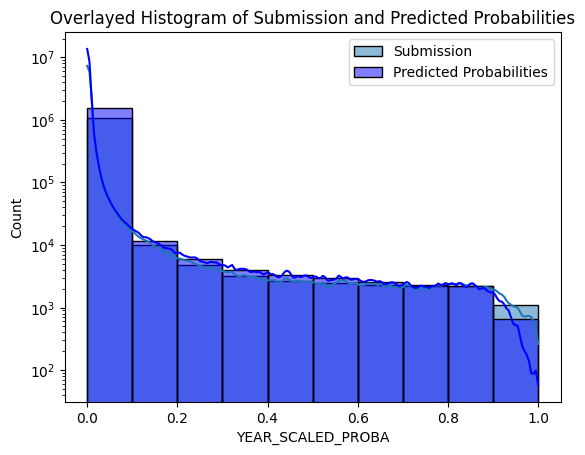

In [119]:
sns.histplot(submission, bins=10, kde=True, label='Submission', alpha=0.5,color='red')
sns.histplot(training_data['YEAR_SCALED_PROBA'], bins=10, kde=True, label='Predicted Probabilities', alpha=0.5, color='blue')
plt.yscale('log')
plt.legend()
plt.title('Overlayed Histogram of Submission and Predicted Probabilities')
plt.show()

In [214]:
magic_number = 2.1
experiment_probs = calculate_probabilities(training_data, 'LOGISTIC_REG', magic_number)
print(experiment_probs.mean(), experiment_probs.max(), experiment_probs.min(), experiment_probs.std())


0.014650493996911831 0.9999634858556221 1.84297022087776e-14 0.0796354768511789


In [215]:
training_data['EXPERIMENT_PROBS'] = experiment_probs
submission_exp = create_submission_file(training_data, 'EXPERIMENT_PROBS', data_submission_example, filename='./predictions/prediction-with-time-param-0-585.csv')

Before centering:
0.9999634858556221 3.164135620181696e-14 0.014850026590304564
Centering probabilities...
0.9999634858556221 3.164135620181696e-14 0.014850026590304564
Saved file: ./predictions/prediction-with-time-param-0-585.csv


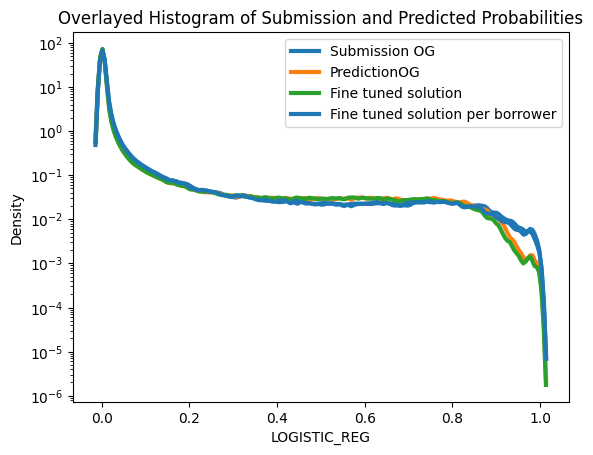

In [216]:
# print(experiment_probs.mean(), experiment_probs.max(), experiment_probs.min(), experiment_probs.std())
sns.kdeplot(submission, label='Submission OG', lw=3, alpha=1)
sns.kdeplot(training_data['LOGISTIC_REG'], label='PredictionOG', lw=3, alpha=1)
sns.kdeplot(experiment_probs, label='Fine tuned solution', lw=3, alpha=1)
sns.kdeplot(submission_exp, label='Fine tuned solution per borrower', lw=3, alpha=1)

plt.yscale('log')
plt.legend()
plt.title('Overlayed Histogram of Submission and Predicted Probabilities')
plt.show()

In [229]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import log_loss
import numpy as np

# Other necessary imports, like pandas, if you're using a DataFrame

def train_and_evaluate(df, variables, target, model=LogisticRegression(), scaler=StandardScaler(), cv_folds=5, augment_distribution=False):
    # Your lognormal_variables transformation code remains the same
    if lognormal_variables is not None:
        df = df.copy()
        for var in lognormal_variables:
            if var == 'CONTRACT_CREDIT_LOSS':
                df[var] = np.log1p(np.abs(df[var]))*np.sign(df[var])
            else:
                df[var] = np.log1p(df[var])

    # Split the data before the given date for training 
    if augment_distribution:
        df_filtered = default_percentage_generator(df, 1.48/100, target)
    else:
        df_filtered = df[df['CONTRACT_DATE_OF_LOAN_AGREEMENT_DATETIME'] < '2016-01-01']
    X_filtered = df_filtered[variables]
    y_filtered = df_filtered[target]
    
    # Scale the filtered features
    X_filtered_scaled = scaler.fit_transform(X_filtered)
    
    # Perform cross-validation and fit the model
    cv_scores = cross_val_score(model, X_filtered_scaled, y_filtered, cv=cv_folds, scoring='neg_log_loss')
    
    print(f"CV Log Loss Scores: {-cv_scores}")
    print(f"Mean CV Log Loss: {-np.mean(cv_scores)}")
    
    # Now fit the model to the entire dataset
    model.fit(X_filtered_scaled, y_filtered)
    
    # Scale the entire dataset to predict probabilities for all records
    X_scaled = scaler.transform(df[variables])
    
    # Predict probabilities using the trained model
    proba = model.predict_proba(X_scaled)[:, 1]

    # Calculate log loss on the full dataset
    full_log_loss = log_loss(df[target], proba)

    print(f"Full Dataset Log Loss: {full_log_loss}")

    return proba, cv_scores, full_log_loss

# You might call the function like this
# probabilities, cv_scores, full_log_loss = train_and_evaluate(df, variables, target)



In [230]:
# RANDOM FORREST
# CV Log Loss Scores: [0.02719089 0.02764513 0.02753959 0.02759813 0.0271936 ]
# Mean CV Log Loss: 0.027433468253452647
# Full Dataset Log Loss: 0.021537244543421808
predicted_probs = 'XGBOOST'
probs, _, _ = train_and_evaluate(
    training_data, 
    X_columns, 
    'TARGET_EVENT_BINARY',
    model=xgb.XGBClassifier(max_depth=3, random_state=42, use_label_encoder=False, eval_metric='logloss'),
    augment_distribution=True
)
training_data[predicted_probs] = probs
print(probs.mean())


0.011345816067598232
5206
1750.5931790499392
CV Log Loss Scores: [0.01608614 0.0167136  0.01626121 0.01525046 0.01486667]
Mean CV Log Loss: 0.015835614637518213
Full Dataset Log Loss: 0.013277898005769687
0.011253619


In [227]:
magic_number = 2
experiment_probs = calculate_probabilities(training_data, 'XGBOOST', magic_number)
print(experiment_probs.mean(), experiment_probs.max(), experiment_probs.min(), experiment_probs.std())


0.013342346 0.99799156 2.9802322e-07 0.092173606


In [228]:
training_data['EXPERIMENT_PROBS_XGB'] = experiment_probs
submission_exp = create_submission_file(training_data, 'EXPERIMENT_PROBS_XGB', data_submission_example, filename='./predictions/xgb-prediction-with-time-param-0-585.csv')

Before centering:
0.9999999999899434 2.980232238769531e-07 0.010291124245856357
Centering probabilities...
1.0 0.004509489563093274 0.014800000000000002
Saved file: ./predictions/xgb-prediction-with-time-param-0-585.csv


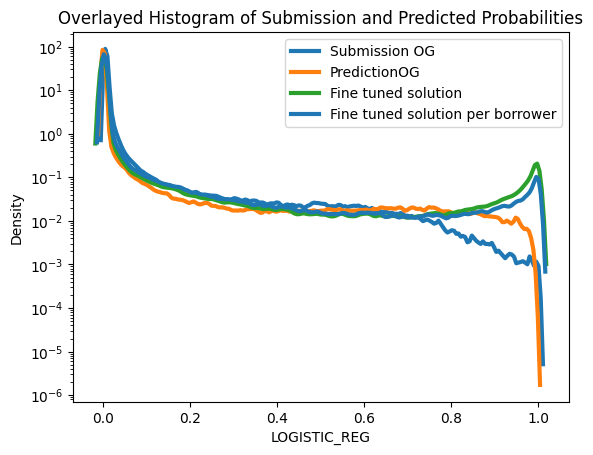

In [127]:
# print(experiment_probs.mean(), experiment_probs.max(), experiment_probs.min(), experiment_probs.std())
sns.kdeplot(submission, label='Submission OG', lw=3, alpha=1)
sns.kdeplot(training_data['LOGISTIC_REG'], label='PredictionOG', lw=3, alpha=1)
sns.kdeplot(experiment_probs, label='Fine tuned solution', lw=3, alpha=1)
sns.kdeplot(submission_exp, label='Fine tuned solution per borrower', lw=3, alpha=1)

plt.yscale('log')
plt.legend()
plt.title('Overlayed Histogram of Submission and Predicted Probabilities')
plt.show()